In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Carga del dataset

In [38]:
bankruptcy = pd.read_csv('https://raw.githubusercontent.com/christianolivamoya/MIAX11-ML/main/data/bankruptcy.csv', index_col='Company')
bankruptcy.head()

,WC/TA,RE/TA,EBIT/TA,S/TA,BVE/BVL,Bankrupt
Company,,,,,,
360Networks,9.3,-7.7,1.6,9.1,3.726,yes
Advanced Radio Telecom,42.6,-60.1,-10.1,0.3,4.130,yes
Ardent Communications,-28.8,-203.2,-51.0,14.7,0.111,yes
At Home Corp.,2.5,-433.1,-6.0,29.3,1.949,yes
Convergent Communications,26.1,-57.4,-23.5,54.2,0.855,yes


In [39]:
features = bankruptcy.drop(columns='Bankrupt')
target = bankruptcy['Bankrupt']

## Normalización

Cuando utilizamos modelos basados en distancias, como K-Nearest Neighbors (KNN) o K-Means, los distintos rangos de valores de los atributos pueden suponer un problema. Es por eso que, lo natural para poder trabajar con ellos, es normalizarlos:

$$x_{norm} = {x - \mu \over \sigma}$$

donde $x$ es nuestra serie original, $\mu$ es la media de la serie y $\sigma$ es la desviación típica.

In [40]:
def normalizar(x):
  return (x - x.mean()) / x.std()

In [41]:
features_scaled = features.apply(normalizar)
features_scaled.head()

,WC/TA,RE/TA,EBIT/TA,S/TA,BVE/BVL
Company,,,,,
360Networks,0.130789,0.502211,0.346543,-0.994526,0.133042
Advanced Radio Telecom,1.102512,-0.079535,-0.093118,-1.279658,0.207512
Ardent Communications,-0.981003,-1.668234,-1.630050,-0.813079,-0.533312
At Home Corp.,-0.067641,-4.220589,0.060951,-0.340019,-0.194513
Convergent Communications,0.621028,-0.049559,-0.596660,0.466773,-0.396170


Vamos a comparar el efecto de haber normalizado los datos. Por supuesto, lo único que va a variar es la escala de las variables. Las distribuciones se mantienen iguales. De esta forma, todos los atributos van a tener el mismo peso en el cálculo de la distancia.

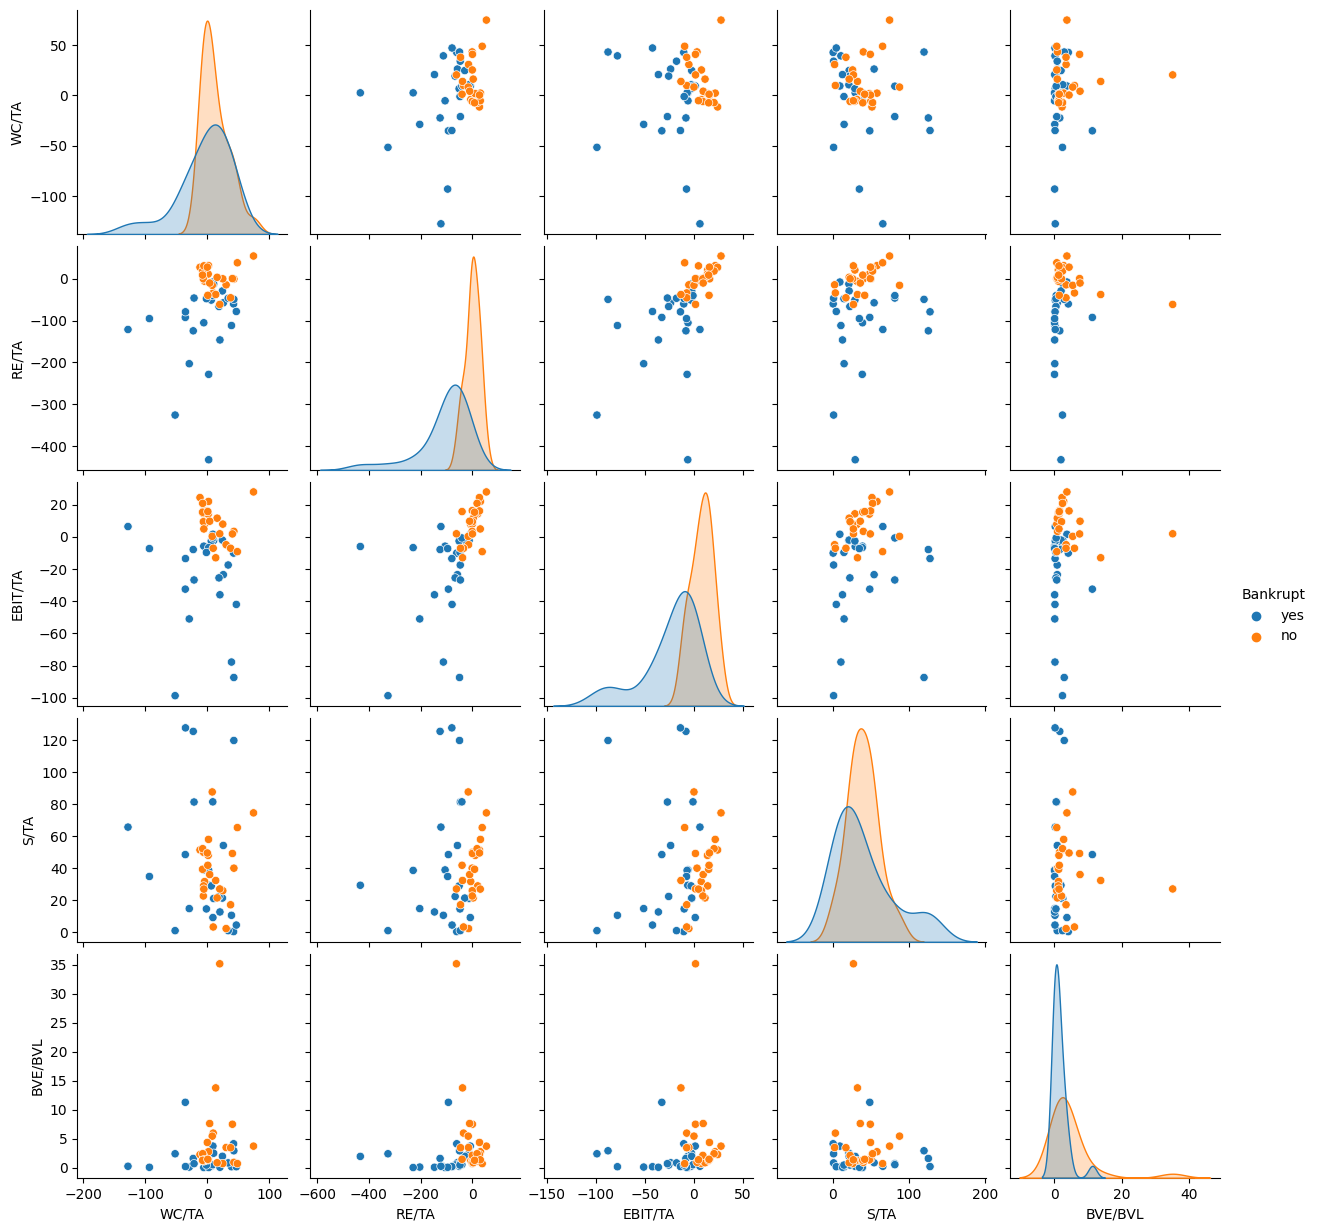

In [42]:
sns.pairplot(pd.concat([features, target], axis=1), hue="Bankrupt")
plt.show()

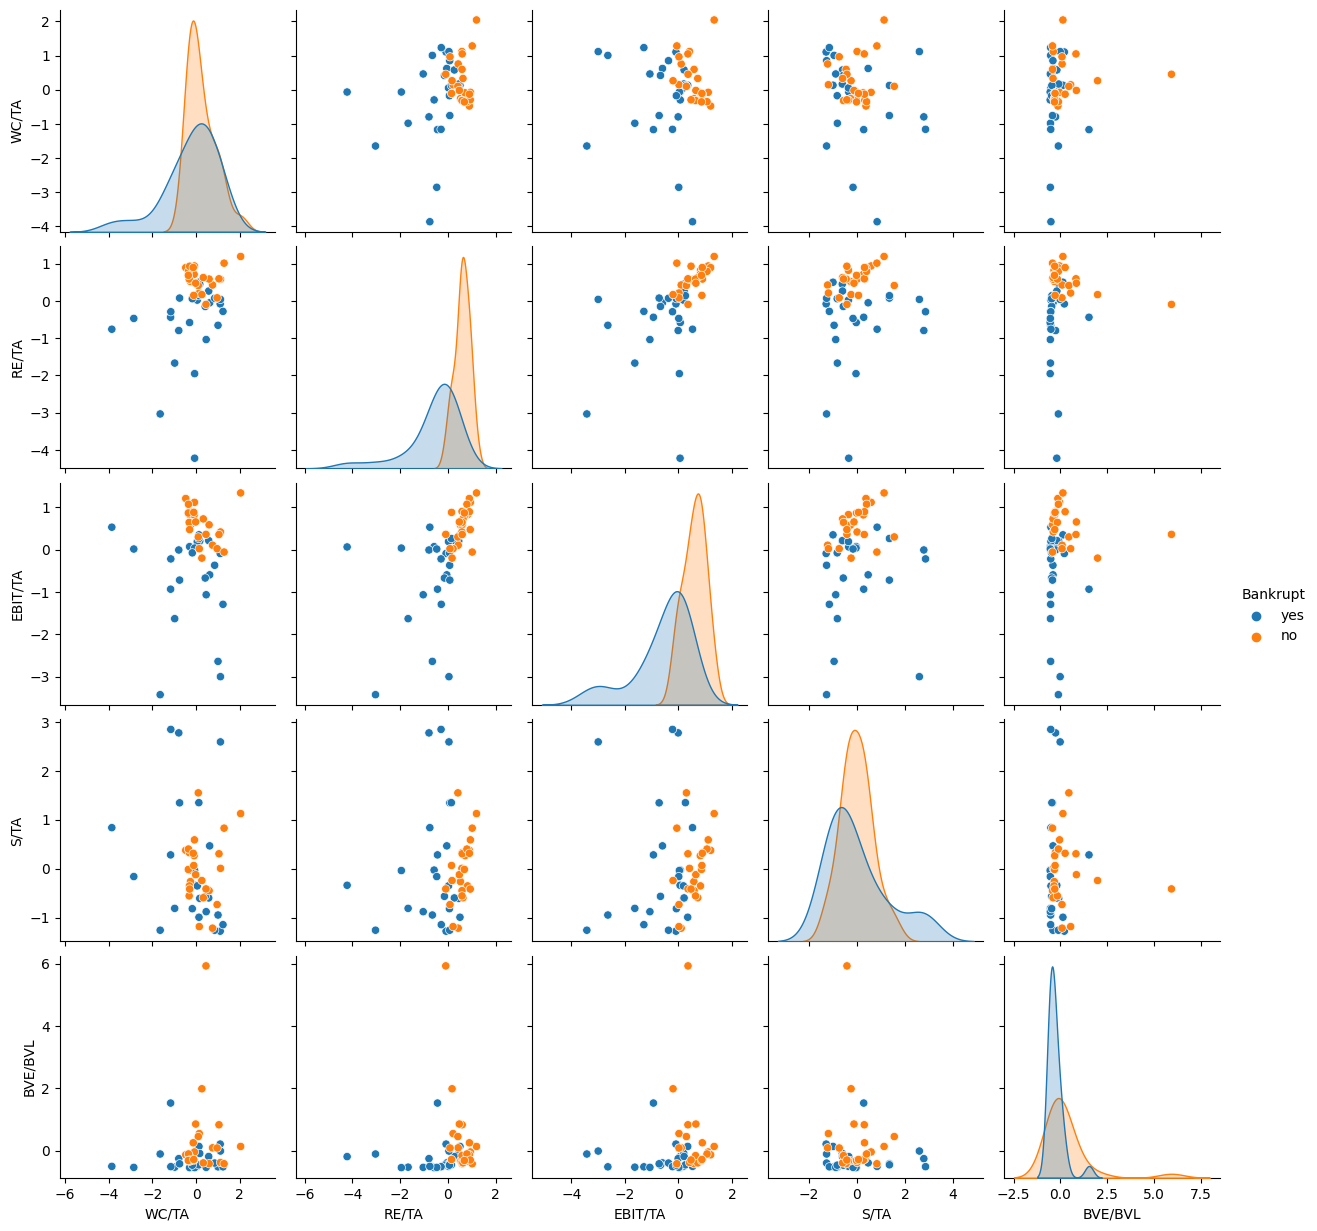

In [43]:
sns.pairplot(pd.concat([features_scaled, target], axis=1), hue="Bankrupt")
plt.show()

# Proyección a 2D para visualizar

Otra alternativa de visualización es utilizar algún tipo de algoritmo para transformar nuestros datos multidimensionales (en concreto, 5 en este dataset) a 2D para poder visualizarlos. Para ello, vamos a utilizar los algoritmos **Isomap** y **MDS** de la librería Sklearn.

Más información en:
https://scikit-learn.org/stable/modules/classes.html#module-sklearn.manifold

In [77]:
from sklearn.manifold import Isomap, MDS

### MDS

MDS (Multidimensional Scaling) es una técnica de análisis estadístico utilizada para visualizar la similitud o la distancia entre puntos de datos en un espacio de menor dimensión. El objetivo principal del MDS es representar objetos o muestras en un espacio euclidiano de baja dimensión de manera que las distancias (o similitudes) entre ellos se preserven de manera óptima en comparación con las distancias (o similitudes) en el espacio original de alta dimensión.

In [80]:
mds = MDS(normalized_stress="auto")
data_2d = mds.fit_transform(features_scaled)

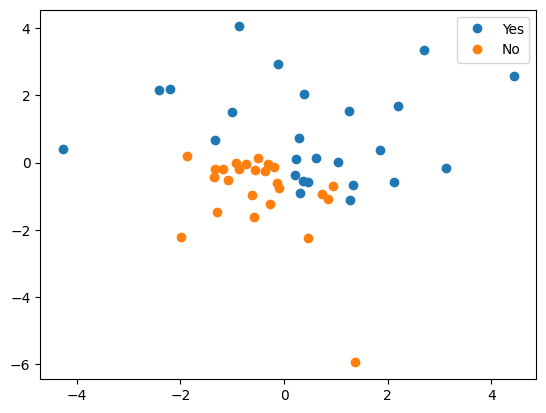

In [81]:
plt.plot(data_2d[target=="yes", 0], data_2d[target=="yes", 1], 'o', label="Yes")
plt.plot(data_2d[target=="no", 0], data_2d[target=="no", 1], 'o', label="No")
plt.legend()
plt.show()

### Isomap

ISOMAP (Isometric Mapping) es un algoritmo de aprendizaje no supervisado utilizado para la reducción de dimensionalidad y la representación de datos en un espacio de menor dimensión. La idea clave detrás de ISOMAP es capturar la estructura subyacente del conjunto de datos, especialmente cuando este se encuentra en un espacio de alta dimensión, de manera que la representación en 2D conserve las relaciones de vecindad y similitud entre los puntos originales.

In [94]:
iso = Isomap(n_neighbors=15)
data_2d = iso.fit_transform(features_scaled)

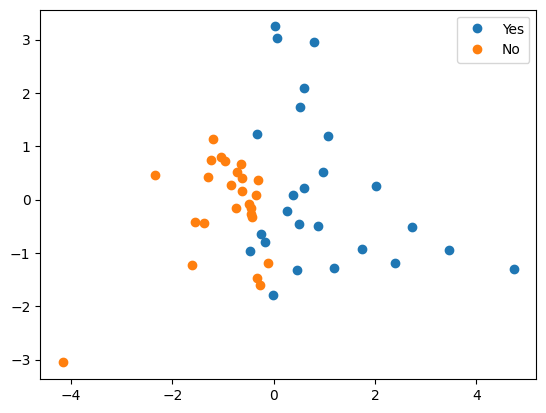

In [95]:
plt.plot(data_2d[target=="yes", 0], data_2d[target=="yes", 1], 'o', label="Yes")
plt.plot(data_2d[target=="no", 0], data_2d[target=="no", 1], 'o', label="No")
plt.legend()
plt.show()

# K-Means

Vamos a clusterizar los datos y luego los visualizaremos con MDS, por ejemplo.

In [82]:
from sklearn.cluster import KMeans

In [83]:
kmeans = KMeans(n_clusters=2, n_init=30).fit(features_scaled)

In [84]:
pd.DataFrame(kmeans.cluster_centers_, columns=features.columns)

,WC/TA,RE/TA,EBIT/TA,S/TA,BVE/BVL
0,0.291284,0.410664,0.351519,-0.168993,0.086247
1,-0.829038,-1.168814,-1.000477,0.480980,-0.245473


In [96]:
clusters = kmeans.predict(features_scaled)
clusters_centroids_2d = iso.transform(kmeans.cluster_centers_)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


array([[-0.55431126, -0.45351779],
       [ 1.48213425,  0.40682697]])

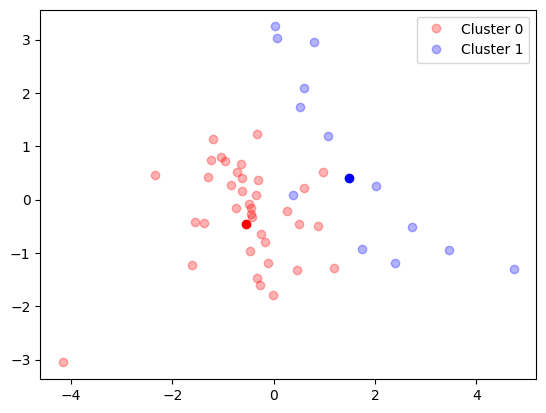

In [98]:
plt.plot(data_2d[clusters==0, 0], data_2d[clusters==0, 1], 'or', alpha=0.3, label="Cluster 0")
plt.plot([clusters_centroids_2d[0, 0]], [clusters_centroids_2d[0, 1]], 'or')
plt.plot(data_2d[clusters==1, 0], data_2d[clusters==1, 1], 'ob', alpha=0.3, label="Cluster 1")
plt.plot([clusters_centroids_2d[1, 0]], [clusters_centroids_2d[1, 1]], 'ob')
plt.legend()
plt.show()

In [120]:
features_scaled_clusters = pd.concat([features_scaled, pd.Series(clusters, name='cluster', index=features_scaled.index)], axis=1)
features_scaled_clusters.sample(5)

,WC/TA,RE/TA,EBIT/TA,S/TA,BVE/BVL,cluster
Company,,,,,,
RSL Communications,0.124953,0.141395,0.260114,1.351330,-0.457553,0
NetVoice Technologies,-0.756310,0.077004,-0.720667,1.348089,-0.425110,1
Gilat Satellite Networks,1.117103,0.583256,0.414183,0.006675,-0.383267,0
Rhythms NetConnections,1.230908,-0.280481,-1.291850,-1.146812,-0.522806,0
SBC Communications,-0.350696,0.794194,1.068036,0.401971,-0.108984,0


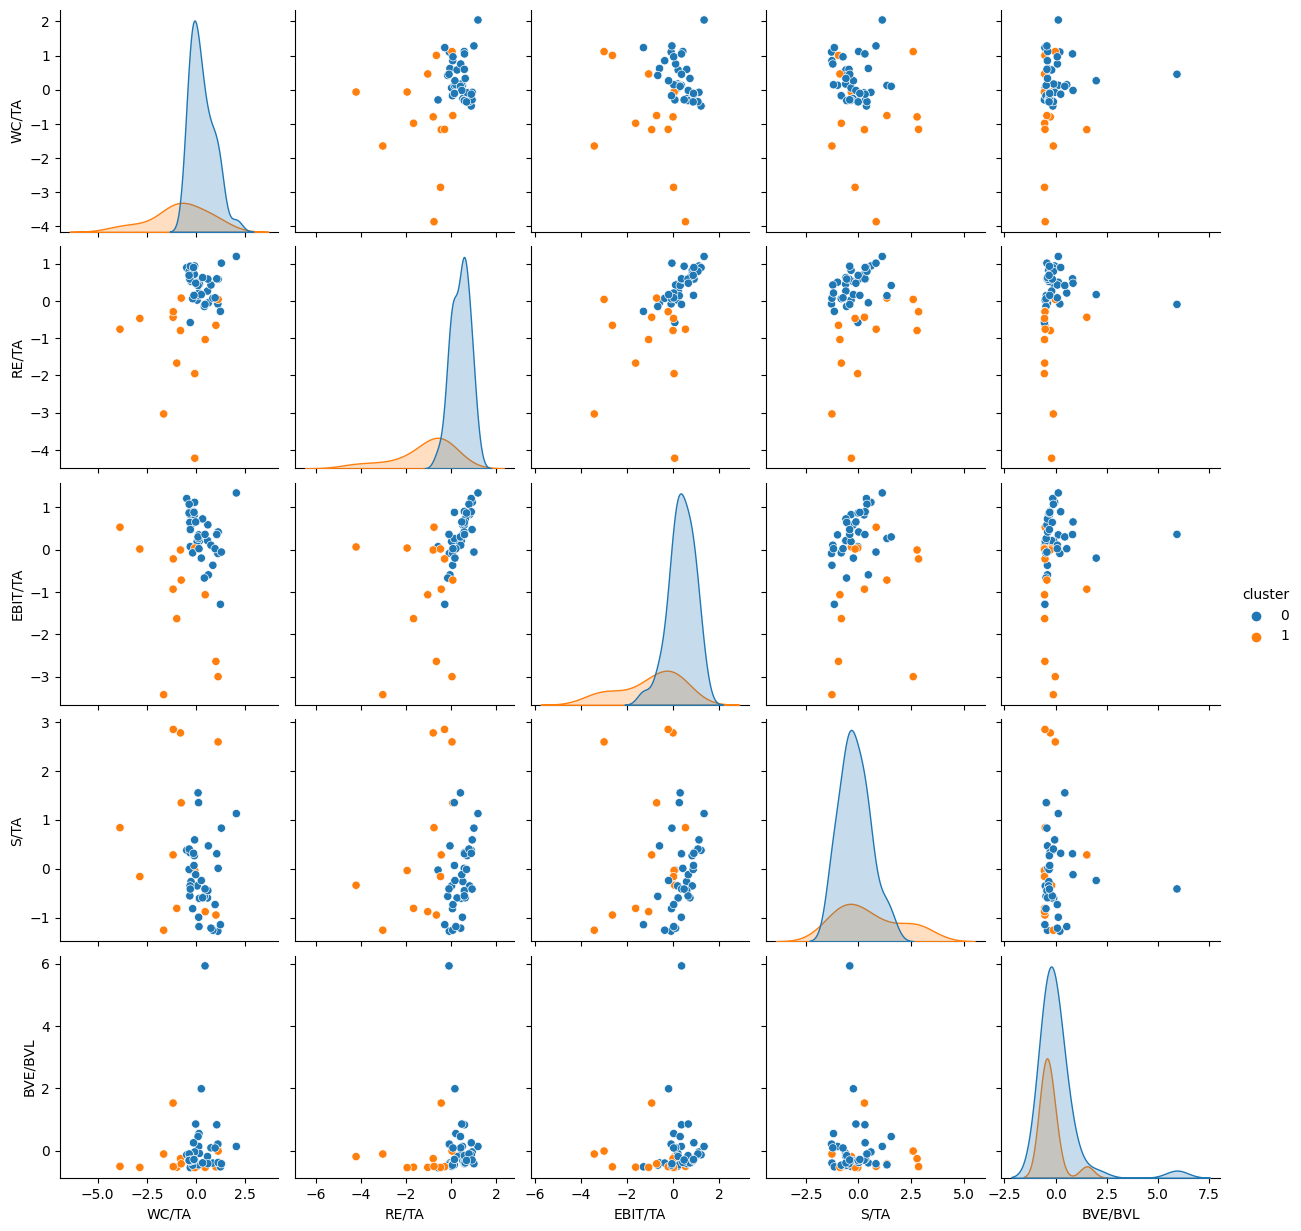

In [121]:
sns.pairplot(features_scaled_clusters, hue="cluster")
plt.show()